# **Black-Scholes RK4 Numerical Solver**
In this notebook, I'll be numerically solving the Black-Scholes PDE, a foundational European options evaluation model. This will be used to benchmark and finetune the PINN which will be approximating the same equation.



---

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$
<center>

**Black-Scholes PDE**
</center>

Where:
* $V$: Option price
* $t$: Time
* $S$: Price of the underlying asset
* $\sigma$: Volatility of the underlying asset's returns
* $r$: Risk-free interest rate


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

# Define parameters
r = 0.05          # Risk-free rate
sigma = 0.2       # Volatility
K = 100           # Strike price
T = 1.0           # Time to maturity (in years)
S_max = 200       # Max stock price in spatial domain
S_min = 0         # Min stock price
N = 100           # Number of spatial grid points

# Discretize stock price (space)
S = np.linspace(S_min, S_max, N)
dS = S[1] - S[0]

# Initial condition at maturity for European call option
V_T = np.maximum(S - K, 0)

# Define rhs of PDE
def black_scholes_rhs(t, V):
    dVdt = np.zeros_like(V)

    for i in range(1, N-1):
        delta = (V[i+1] - V[i-1]) / (2*dS)
        gamma = (V[i+1] - 2*V[i] + V[i-1]) / (dS**2)
        
        dVdt[i] = -0.5 * sigma**2 * S[i]**2 * gamma \
                  - r * S[i] * delta + r * V[i]

    # Boundary conditions
    dVdt[0] = 0  # V=0 at S=0
    dVdt[-1] = r * (S[-1] - K) - r * V[-1]  # linear payoff behavior at high S

    return dVdt

# Reverse time interval: solve backward from maturity
sol = solve_ivp(
    fun=black_scholes_rhs,
    t_span=[T, 0],            # backward integration
    y0=V_T,                   # initial value at maturity
    t_eval=np.linspace(T, 0, 200),  # time points to evaluate
    method='RK45'
)

## **Lineplot**

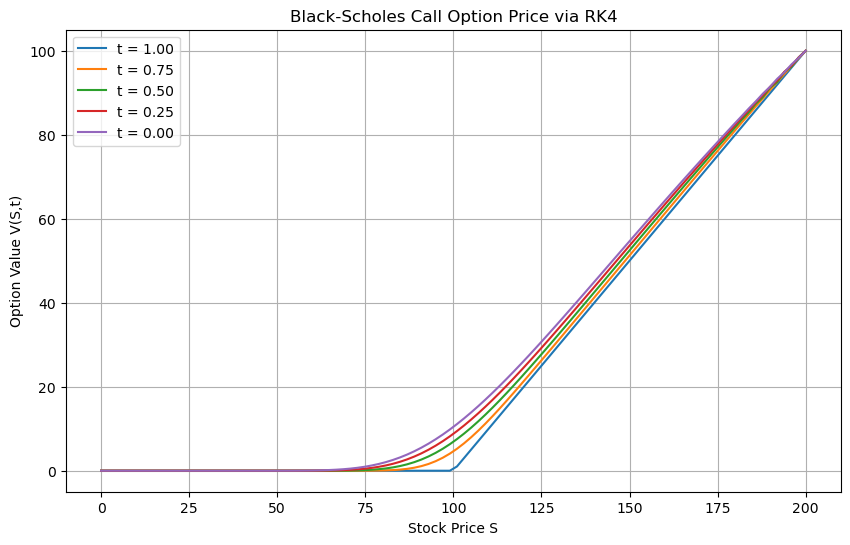

In [5]:
# Pick time slices to visualize
plt.figure(figsize=(10, 6))
for idx in [0, 50, 100, 150, 199]:
    plt.plot(S, sol.y[:, idx], label=f"t = {sol.t[idx]:.2f}")
plt.title("Black-Scholes Call Option Price via RK4")
plt.xlabel("Stock Price S")
plt.ylabel("Option Value V(S,t)")
plt.legend()
plt.grid(True)
plt.show()

## **Heatmap**

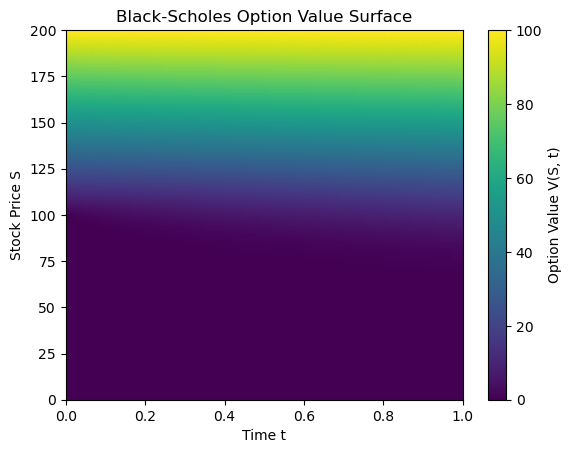

In [6]:
plt.imshow(sol.y, extent=[0, T, S_min, S_max], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Option Value V(S, t)')
plt.xlabel('Time t')
plt.ylabel('Stock Price S')
plt.title('Black-Scholes Option Value Surface')
plt.show()


## **3D Surface Plot**

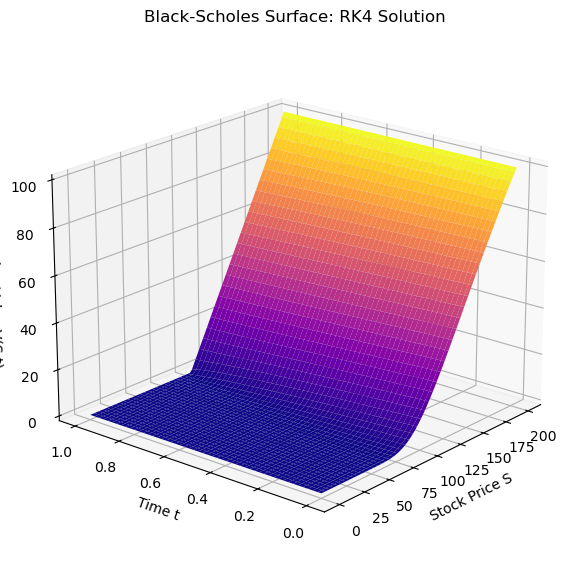

In [17]:
from mpl_toolkits.mplot3d import Axes3D

S_grid, T_grid = np.meshgrid(S, sol.t)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, sol.y.T, cmap='plasma')
ax.set_xlabel('Stock Price S')
ax.set_ylabel('Time t')
ax.set_zlabel('Option Value V(S,t)')
ax.set_title('Black-Scholes Surface: RK4 Solution')
ax.view_init(elev=20, azim=220)

plt.show()